# Strategy idea: 

## Returns on the first working day of the month are positive

"Since the late 80s there has been a tendency for the market to rally on the first day of the month.  One theory on why this occurs is that there are often 401k inflows that are put to work on the 1st of the month. "

If the above statement is true, this is possibly a structural alpha source that can be exploited. Also worth investigating if other dates (month-end) are profitable. 

Based on research from QuantifiableEdges: https://quantifiableedges.com/first-day-of-month-based-on-month/

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
tickers = [
    'SPY',
#     '^GSPC'
#     'QQQ',
#     'CUKX.L',
           ]

yday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')

start_date = '1990-01-01'
end_date = yday

panel_data = data.DataReader(tickers , 'yahoo', start_date, end_date)

In [3]:
close_data = panel_data.loc[:, ('Close', slice(None))]
close_data.columns = close_data.columns.droplevel()

In [4]:
panel_data.columns


MultiIndex([('Adj Close', 'SPY'),
            (    'Close', 'SPY'),
            (     'High', 'SPY'),
            (      'Low', 'SPY'),
            (     'Open', 'SPY'),
            (   'Volume', 'SPY')],
           names=['Attributes', 'Symbols'])

In [5]:
first_bd_df = panel_data[['Open', 'Close']].resample('M').first() 
# index dates display end of month, but values relate to start of month
first_bd_df['daily_change'] = first_bd_df['Close'] / first_bd_df['Open'] - 1
first_bd_df

Attributes,Open,Close,daily_change
Symbols,SPY,SPY,
Date,,,
1993-01-31,43.968750,43.937500,-0.000711
1993-02-28,43.968750,44.250000,0.006397
1993-03-31,44.562500,44.281250,-0.006311
1993-04-30,45.250000,45.031250,-0.004834
1993-05-31,44.093750,44.312500,0.004961
...,...,...,...
2020-03-31,298.209991,309.089996,0.036484
2020-04-30,247.979996,246.149994,-0.007380


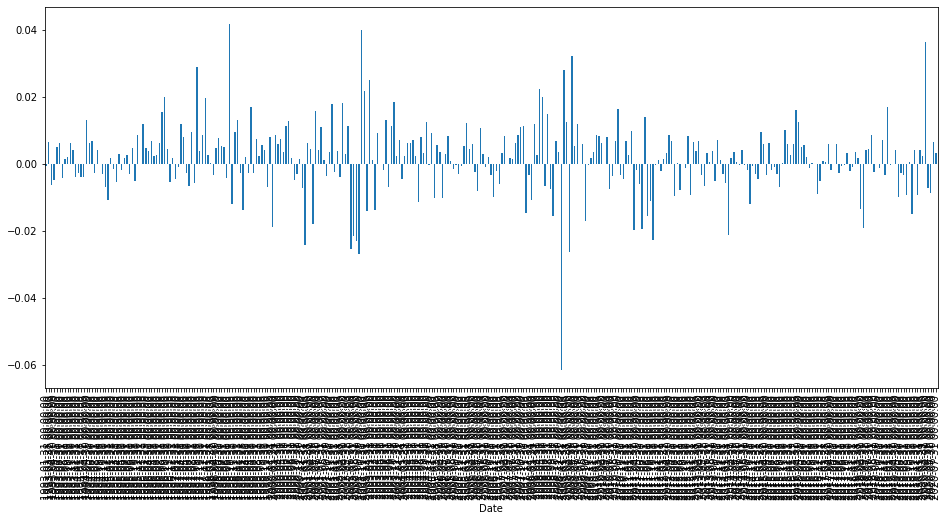

In [6]:
first_bd_df.loc[:, 'daily_change'].plot(kind = 'bar', figsize = (16, 7));
# first_bd_df.loc['2000':, 'daily_change'].plot(kind = 'bar', figsize = (16, 7));

Yahoo Data for SPX starts in 1993 and it appears that there is a fairly even mix of months where the return on the first business day was negative vs positive.

In [7]:
n_months = first_bd_df.shape[0]
n_months_positive = first_bd_df.loc[first_bd_df['daily_change'] >= 0, 'daily_change'].shape[0]
n_months_negative = n_months - n_months_positive

pct_months_positive = n_months_positive / n_months
pct_months_negative = n_months_negative / n_months

print('Positive months %:', round(pct_months_positive * 100, 4), '%')
print('Negative months %:', round(pct_months_negative * 100, 4), '%')

Positive months %: 58.3082 %
Negative months %: 41.6918 %


Overall, there are slightly more positive months. Does this persist over time, or is this a fading/increasing trend? 

In [8]:
yrs = pd.Series(first_bd_df.resample('Y').first().index)
yrs = yrs.dt.strftime('%Y').values

pct_pos = []
pct_neg = []

for yr in yrs:
    temp_df = first_bd_df.loc[yr, 'daily_change']
    pos = temp_df.loc[temp_df >= 0].shape[0] / temp_df.shape[0]
    pct_pos.append(pos)
    pct_neg.append(1 - pos)
    
yearly_split_df = pd.DataFrame({'positive_%': pct_pos, 'negative_%': pct_neg}, index = yrs)

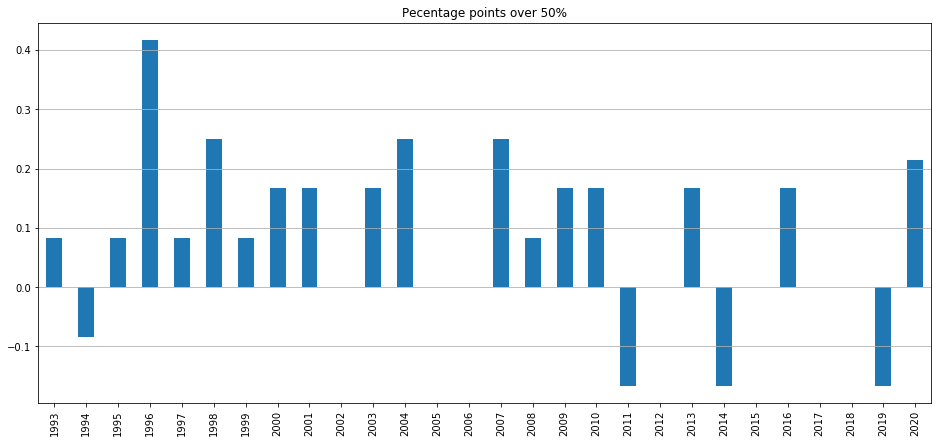

In [9]:
(yearly_split_df['positive_%'] - .5).plot(
    kind = 'bar', 
    figsize = (16, 7), 
    title = 'Pecentage points over 50%'
)
plt.grid(axis = 'y');

Looks like for most years, this strategy is profitable. That said, it looks like this has broken in recent years. In the last decade, this strategy worked only 50% of the time. An analysis of the actual returns would be interesting.

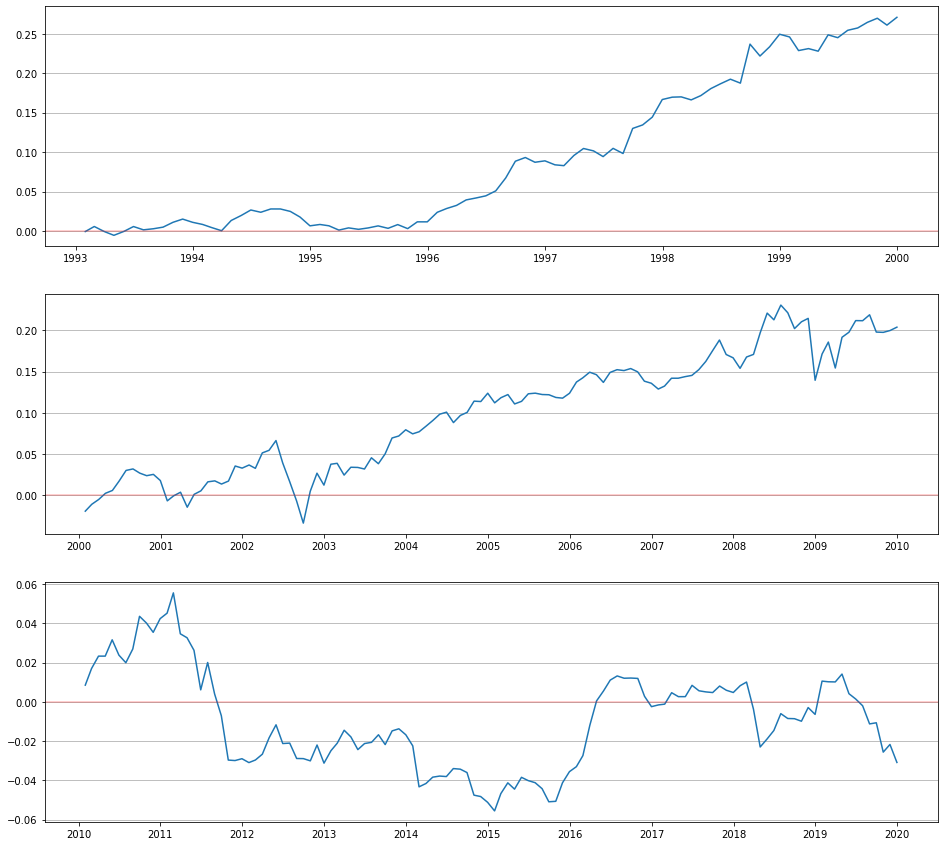

In [11]:
cumulative_90s_returns = np.cumprod(1 + first_bd_df.loc['1990':'1999', 'daily_change']) - 1
cumulative_00s_returns = np.cumprod(1 + first_bd_df.loc['2000':'2009', 'daily_change']) - 1
cumulative_10s_returns = np.cumprod(1 + first_bd_df.loc['2010':'2019', 'daily_change']) - 1

returns_list = [cumulative_90s_returns, cumulative_00s_returns, cumulative_10s_returns]
i = 1
plt.figure(figsize = (16,15))

for x in returns_list:
    plt.subplot(3, 1, i)
    plt.plot(x)
    plt.grid(axis = 'y')
    plt.axhline(color = 'r', alpha = .25)
    i += 1

plt.show()

## Conclusion: 
For the SPY, this strategy made money in the 90s and also in the 2000s. It has since broken down in the past decade. Worth investigating if it exists in other markets. 

Running `^GSPC` instead of `SPY` (the ETF) shows the 2010s are profitable. Interesting that there is a difference between them. Possibly some impact of ETF rebalancing 